In [1]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
# spacy for lemmatization
import spacy
import re
import numpy as np
import pandas as pd
from pprint import pprint
import glob
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn import tree, metrics
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import os

In [2]:
##find topic names
f=open("./plots/neuralnetwork-topics-50-labeled.txt","r")
featuretext=f.read().lower()
lines=featuretext.split("\n")
feature_names=[]
for line in lines:
    if 'topic' in line:
        feature_names.append(' '.join(line.split()[1:]))
print(len(feature_names))

50


In [3]:
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path

mallet_model=gensim.models.LdaModel.load('./models/model-050')

##pprint(mallet_model.print_topics(50,30))

##unwrap the model
model=gensim.models.wrappers.ldamallet.malletmodel2ldamodel(mallet_model, gamma_threshold=0.001, iterations=50)

In [4]:
##a clearer rendering of topic words
topics=[topic[1] for topic in model.show_topics(num_topics=50,num_words=30, formatted=False)]
topwords=[]
f=open("./plots/"+str(50)+"topicwords.csv","w")
for topic in topics:
    topicwords=[]
    for topicword in topic:
        topicwords.append(topicword[0])
        f.write(topicword[0]+",")
        topicstring="  ".join(topicwords)
    f.write("\n")
    topwords.append(topicstring)
f.close()
for idx, topword in enumerate(topwords):
    print ("Topic"+str(idx)+"\n"+topword+"\n_____________________________________________________________________________________________________________________")
    print ()

    
    
    
    

Topic0
deal  iran  israel  russia  agreement  nuclear  world  war  bomb  russian  support  country  jewish  sanction  putin  peace  iranian  nation  israeli  cuba  international  jew  ukraine  west  negotiate  palestinian  attack  leader  power  japan
_____________________________________________________________________________________________________________________

Topic1
question  point  answer  fact  wrong  agree  argument  reason  case  base  correct  simply  make  suggest  view  assume  completely  clear  argue  simple  statement  disagree  response  opinion  reasonable  logic  position  side  present  give
_____________________________________________________________________________________________________________________

Topic2
gun  people  control  kill  fear  act  violence  shoot  stop  hand  carry  fire  murder  death  threat  weapon  dangerous  happen  attack  nra  responsible  public  tragedy  blame  mass  victim  safety  protect  afraid  safe
___________________________

In [5]:
##vaxx files
files = glob.glob('../documents/vaxx/*.txt')
print(len(files))
files=np.random.choice(files,int(len(files)))
print(len(files))
data = []
for f in files:
    with open(f, 'r') as fin:
        data.append(fin.read())

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data_words = list(sent_to_words(data))

1101
1101


In [5]:
files = glob.glob('../documents/comments/comments/*.txt')
print(len(files))
files=np.random.choice(files,int(len(files)))
print(len(files))
data = []
for f in files:
    with open(f, 'r') as fin:
        data.append(fin.read())

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data_words = list(sent_to_words(data))

445441
445441


## Preprocess ##

In [8]:
def preprocess(input):
    from nltk.corpus import stopwords
    stop_words = set(stopwords.words('english'))

    bigram = gensim.models.Phrases(input, min_count=5, threshold=100) # higher threshold fewer phrases.
    
    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
   
    # See trigram example
    def remove_stopwords(texts):
        return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

    def make_bigrams(texts):
        return [bigram_mod[doc] for doc in texts]

   
    def lemmatization(texts, allowed_postags=set(['NOUN', 'ADJ', 'VERB', 'ADV'])):
        """https://spacy.io/api/annotation"""
        texts_out = []
        for sent in texts:
            doc = nlp(" ".join(sent)) 
            texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        return texts_out

    # Remove Stop Words
    data_words_nostops = remove_stopwords(input)

    # Form Bigrams
    data_words_bigrams = make_bigrams(data_words_nostops)

    # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
    # python3 -m spacy download en
    nlp = spacy.load('en', disable=['parser', 'ner'])
    nlp.max_length = 9297925
    # Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=set(['NOUN', 'ADJ', 'VERB', 'ADV']))
    return data_lemmatized
# Create Dictionary
id2word = mallet_model.id2word
# Create Corpus
texts = preprocess(data_words)
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1])
X=np.asarray(model.inference(corpus)[0])
num_topics=len(X[0])
##normalize it
X=(X.T/np.sum(X,axis=1)).T
Y=np.asarray([len(text) for text in texts])
useless_topics=[6,12,19,21,30,35,38,44]##remove non-topical features
for useless_topic in useless_topics:
    X[:,useless_topic]=0

    


[[(106, 1), (108, 1), (128, 1), (223, 1), (279, 1), (306, 1), (329, 1), (403, 1), (430, 1), (549, 1), (675, 1), (866, 1), (959, 1), (979, 1), (1089, 1), (1210, 1), (1220, 1), (1380, 1), (1502, 1), (1698, 1), (1725, 1), (2081, 1), (2267, 1), (2344, 1), (2551, 1), (2894, 1), (3094, 1), (27388, 1), (87021, 1)]]


## Mask out comments ##

In [ ]:
#new edit: mask out least topics    
masked_X = np.empty(X.shape)
for i in range(X.shape[0]):
    max5topic = np.sort(X[i, :])[::-1][9] #last index is number of topic to keep-1
    mask = max5topic<=X[i, :]
    masked_X[i, :] = mask*X[i, :]
    masked_X[i, :]/=np.sum(masked_X[i, :])

print(masked_X.shape)

(311808, 50) (133633, 50)
(311808, 50) (133633, 50)


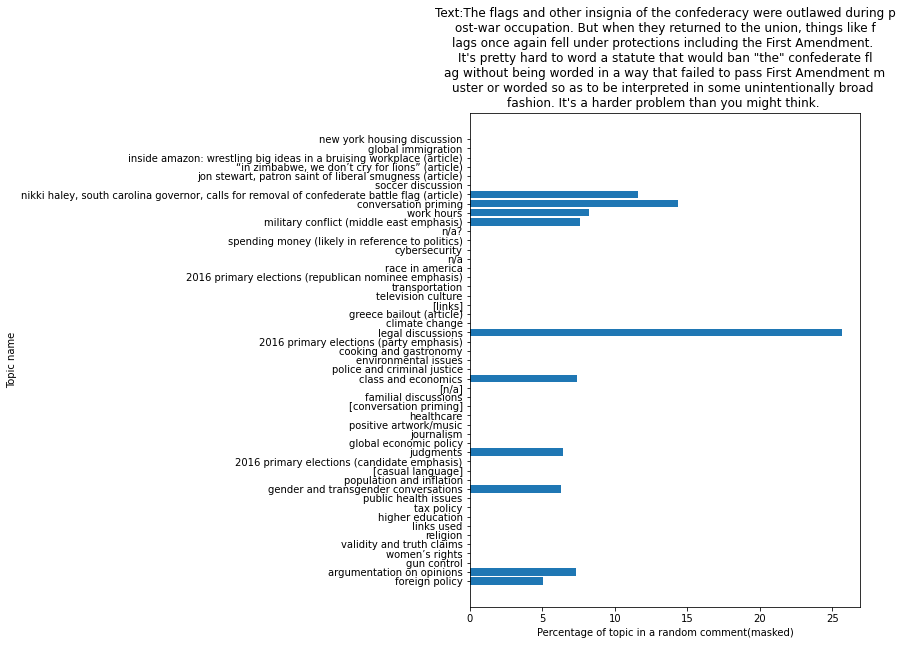

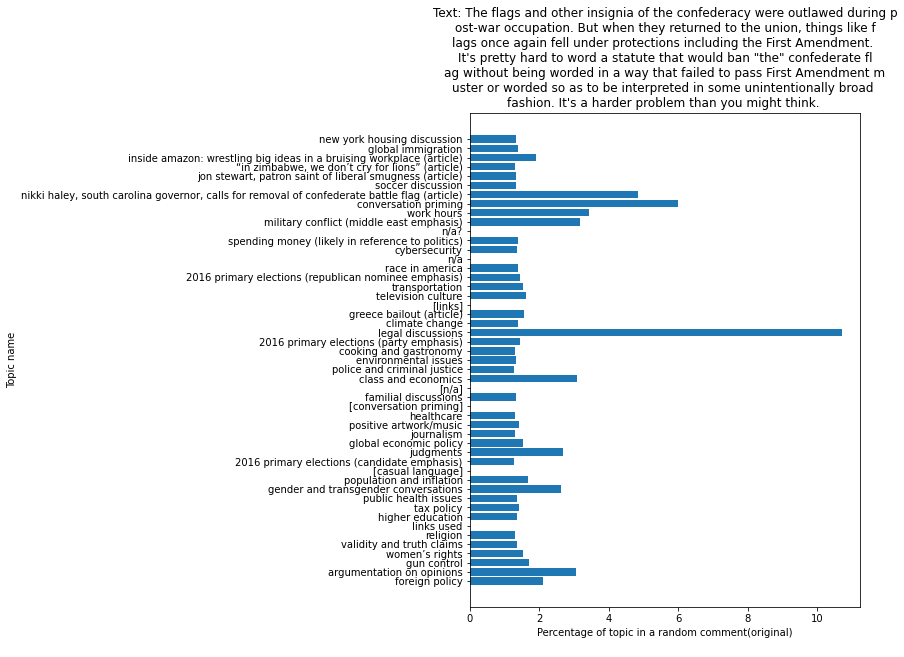

In [27]:
plt.figure(figsize = (7, 20))
plt.subplot(211)
plt.barh(feature_names,masked_X[2]*100)
#plt.yticks(fontsize=6)
linebreakedtext = ''.join([letter if i%70!=69 else letter+'\n' for i, letter in enumerate(data[2])])
plt.title('Text:'+ linebreakedtext)
plt.ylabel('Topic name')
plt.xlabel('Percentage of topic in a random comment(masked)\n')
plt.savefig('./plots/topicpercentage_masked.png',dpi=300, bbox_inches = "tight")
plt.figure(figsize = (7, 20))
plt.subplot(212)
plt.barh(feature_names,X[2]*100)
#plt.yticks(fontsize=6)
plt.title('Text: '+ linebreakedtext)
plt.ylabel('Topic name')
plt.xlabel('Percentage of topic in a random comment(original)\n')
plt.savefig('./plots/topicpercentage.png',dpi=300, bbox_inches = "tight")


masked_X_train, masked_X_test = masked_X[:int(len(masked_X)*0.7), :], masked_X[int(len(masked_X)*0.7):, :]
X_train, X_test = X[:int(len(X)*0.7), :], X[int(len(X)*0.7):, :]
print(masked_X_train.shape, masked_X_test.shape)
print(X_train.shape, X_test.shape)

## Compute Sentiment and split

In [28]:
analyser = SentimentIntensityAnalyzer()
scores = [analyser.polarity_scores(sent)['compound'] for sent in data]

scores = np.array(scores)
train_idx = int(len(data)*0.7)
train_scores, test_scores = scores[:train_idx], scores[train_idx:]

## Unmasked Classification

In [122]:
cls = MLPClassifier(max_iter = 200) #neural network
cls = cls.fit(X_train, train_scores>0)
preds = cls.predict(X_test)

/home/joseph/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:573: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [123]:
confusion = metrics.precision_recall_fscore_support(test_scores > 0, preds > 0)[:3]
confusion = pd.DataFrame(confusion, index = ['precision', 'recall', 'f_score'], 
                         columns = ['negative', 'positive'])
acc = metrics.accuracy_score(test_scores > 0, preds > 0)
acc = pd.DataFrame({'accuracy': acc}, index = [''])
display(acc)
display(confusion)
confusion.to_html('plots/confusion.html')

,accuracy
,0.660406


,negative,positive
precision,0.643275,0.679549
recall,0.691676,0.630263
f_score,0.666598,0.653979


32512

## Masked Classification

In [222]:
cls = MLPClassifier(max_iter = 200) #neural network
cls = cls.fit(masked_X_train, train_scores>0)
preds = cls.predict(masked_X_test)

/home/joseph/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:573: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [223]:
confusion = metrics.precision_recall_fscore_support(test_scores > 0, preds > 0)[:3]
confusion = pd.DataFrame(confusion, index = ['precision', 'recall', 'f_score'], 
                         columns = ['negative', 'positive'])


acc = metrics.accuracy_score(test_scores > 0, preds > 0)
acc = pd.DataFrame({'accuracy': acc}, index = [''])
display(acc)
display(confusion)
confusion.to_html('plots/confusion-masked.html')

,accuracy
,0.659291


,negative,positive
precision,0.662957,0.656160
recall,0.622122,0.695119
f_score,0.641891,0.675078


## Unmasked Regression

In [29]:
rgs = MLPRegressor(max_iter = 200) #neural network
rgs=rgs.fit(X_train, train_scores)
preds = rgs.predict(X_test)

print('pearson R and p-value:', pearsonr(preds, test_scores))

pearson R and p-value: (0.5019809947027571, 0.0)


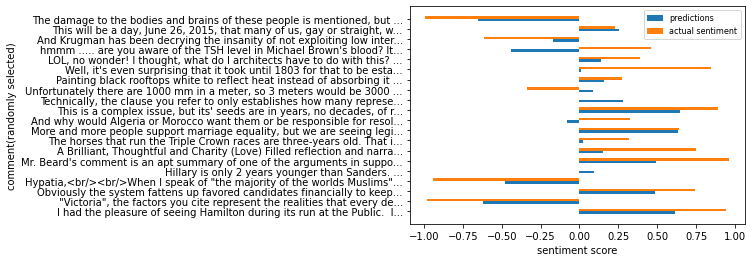

In [63]:
plt.figure()
indices = np.arange(len(test_scores))
np.random.shuffle(indices)
indices = indices[:20]
pred_texts = [data[index+int(0.7*len(data))] for index in indices]
pred_texts_truncated = [data[index+int(0.7*len(data))][:70]+'...' for index in indices]
plt.barh(np.arange(20), preds[indices], 0.25)
plt.barh(np.arange(20)+0.25, test_scores[indices], 0.25)
plt.legend(['predictions', 'actual sentiment'], fontsize = 8)
plt.yticks(np.arange(0, 20)+0.125, pred_texts_truncated)
plt.ylabel('comment(randomly selected)')
plt.xlabel('sentiment score')
plt.savefig('./plots/predvstruth.png',dpi=500, bbox_inches = "tight")
pd.DataFrame(pred_texts).to_csv('./plots/pred_texts.csv')

## Masked Regression

In [31]:
rgs = MLPRegressor(max_iter = 200) #neural network
rgs=rgs.fit(masked_X_train, train_scores)
preds_masked = rgs.predict(X_test)

print('pearson R and p-value:', pearsonr(preds_masked, test_scores))

pearson R and p-value: (0.4297325410779766, 0.0)


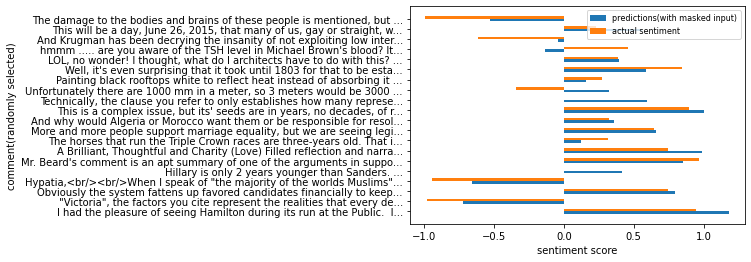

In [64]:
plt.figure()
plt.barh(np.arange(20), preds_masked[indices]*5, 0.25)
plt.barh(np.arange(20)+0.25, test_scores[indices], 0.25)
plt.legend(['predictions(with masked input)', 'actual sentiment'], fontsize = 8)
plt.yticks(np.arange(0, 20)+0.125, pred_texts_truncated)
plt.ylabel('comment(randomly selected)')
plt.xlabel('sentiment score')
plt.savefig('./plots/predvstruth_masked.png',dpi=500, bbox_inches = "tight")

## EDA

In [13]:
useful_topics = [i for i in range(0, 50) if i not in useless_topics]
useful_topics_names = [feature_names[i] for i in useful_topics]

In [15]:
topicnames_words = pd.DataFrame([topwords[idx] for idx in useful_topics], index = useful_topics_names, columns = [''])
topicnames_words.to_csv('./plots/topicnames_words.csv')

In [11]:
plt.tight_layout()
average_sent = {}
for i in range(0, 50):
    average_sent[i] = []
for i in range(X.shape[0]):
    max_topic = np.argmax(X[i])
    average_sent[max_topic].append(scores[i])
average_sent_vector = [np.mean(average_sent[i]) for i in useful_topics]

plt.figure(figsize=(6, 10))
plt.yticks(fontsize=10)
plt.barh(useful_topics_names, average_sent_vector)
plt.xlabel("average topic sentiment score")
plt.ylabel('Topic name')
plt.savefig('./plots/averagesentpertopic.png',dpi=500, bbox_inches = "tight")


plt.figure(figsize=(6, 10))
plt.yticks(fontsize=10)
plt.barh(useful_topics_names, [len(average_sent[i]) for i in useful_topics])
plt.ylabel('Topic name')
plt.xlabel('Number of comments under each topoic')
plt.savefig('./plots/numcommentsundertopic.png',dpi=500, bbox_inches = "tight")

NameError: name 'scores' is not defined

<Figure size 432x288 with 0 Axes>

In [ ]:
print(topicwords[])

## Sorting comments (Not in article, seems bad)##

In [14]:
#separate comments into groups
group_indices = {}
for i in useful_topics:
    group_indices[i] = []
for i, topic_distro in enumerate(X):
    max_topic = np.argmax(topic_distro)
    group_indices[max_topic].append(i)
comments_sorted = {}
scores_sorted = {}
for i in useful_topics:
    group_idx = np.array(group_indices[i], dtype = int) #indices under a topic
    scores_by_group = np.array(scores)[group_idx] #scores under a topic
    comments = np.array(data)[group_idx] #comments under a topic
    scores_order = np.argsort(scores_by_group)[::-1] #sorting by scores
    scores_high_to_low = np.array(scores_by_group)[scores_order] #sorted scores
    comments = np.array(comments)[scores_order] #sorted comments
    comments_sorted[i] = comments
    scores_sorted[i] = scores_high_to_low

In [17]:
pd.options.display.max_colwidth = 200
pd.options.display.max_rows = 500
for group in useful_topics:
    name = feature_names[group]
    sortbytopic = pd.DataFrame({'comments':comments_sorted[group], 'scores':scores_sorted[group]})
    plt.figure()
    display(sortbytopic)
    sortbytopic.to_csv('plots/sortbysent/'+name.replace('/','|')+'.csv')
    break

,comments,scores
0,"Let's employ your advice: ""The history of U.S.-Middle East relations...[is] not one of unqualified kindness and altruism. American oil companies pumped billions of barrels of Arabian oil not for t...",0.9920
1,"Perhaps you can answer how this deal is the best hope for peace. And peace where, because as far as I know this US isn't at war with Iran? Do you think that this deal is going to cause Iran to r...",0.9708
2,"Israel simply another theocracy, Ms Valdez? Seems like people like you are so ignorant of the reality in Israel, that it would be funny if it wouldn't be so outrageous. Israel is a flourishing dem...",0.9660
3,"I am profoundly disappointed by, and opposed to, Senator Schumer's announced decision to vote against the Nuclear Agreement negotiated with Iran. The proposed agreement is in the best interests of...",0.9643
4,"All Americans, including American Jews, are united in our opposition to a nuclear-armed Iran. <br/><br/>We need to recognize that this agreement is a lousy deal - the product of poor negotiating ...",0.9602
5,"Thanks for your service and taking an interest in this problem involving the whole world. I am qualified in submarines and come from a time of stand-off policies and actions against the USSR, a fo...",0.9601
6,"I do not believe anything Obama says or trust anything he does and worst part is I am a democrat. That said, there are few options now available that can be done or undone. Obama negotiated for h...",0.9519
7,Except I don't feel more secure<br/>An agreement allows us to seek another agreement or an improved agreement<br/>Rejecting the international agreement means no more diplomacy<br/>Forget Iran the ...,0.9499
8,"The point of sanctions is to achieve a goal of changing the actions of the subjected nation. But to realize that goal, there needs to be a capitulation by the nation that was sanctioned. The neg...",0.9428
9,"Obama's vetoes have had a perfect record: 4 vetoes, 0 overrides. The only president with a better record was Lyndon Johnson (30-0). Statistically at least the odds are on Obama's side. But with...",0.9417


<Figure size 432x288 with 0 Axes>

## Finding closest comment##

In [55]:
example_idx = 4
example = X[example_idx]
## calculate cosine similarity
cos_sims = np.dot(X, example)/np.linalg.norm(X, axis = 1)/np.linalg.norm(example)
order = np.argsort(cos_sims)[::-1]
order = order[1:5]
print('example comment(randomly selected):\n', data[example_idx])
print('most similar comments:')
for num, i in enumerate(order):
    print(num, ':', data[i], cos_sims[i])

example comment(randomly selected):
 sdga161  That is a question that has been posed many times and the pro life people tend to be very uncomfortable if they also are conservative Christians who also denounce homosexuality.  
most similar comments:
0 : Your personal beliefs and life decisions regarding this divisive issue should of course be respected by others. 0.9634321381227459
1 : What about us atheists? Why should your view determine how I want to die? 0.962755252620447
2 : When belief takes hold, reason falls by the wayside. 0.9603354961954446
3 : Christ showed us by his own example exactly how important it is to spend your free time dwelling on the sex lives of strangers.  Yep.  It’s exactly that important to Jesus. 0.9553689347768646


In [79]:
# make topic vector for article
with open('inside_amazon.txt') as file:
    article_text = [file.read()]
article = list(sent_to_words(article_text))
article = preprocess(article)
article = [id2word.doc2bow(text) for text in article]
article=np.asarray(model.inference(article)[0])
article = (article.T/np.sum(article,axis=1)).T
article.shape
for useless_topic in useless_topics:
    article[:,useless_topic]=0
    
    

example = article[0]
## calculate cosine similarity
cos_sims = np.dot(X, example)/np.linalg.norm(X, axis = 1)/np.linalg.norm(example)
order = np.argsort(cos_sims)[::-1]
order = order[0:100]
#print('article', article_text)
print('most similar comments')
for num, i in enumerate(order):
    print(num, ':', data[i], cos_sims[i])
most_relevant_amazon = [[data[i], cos_sims[i]] for i in order]
pd.DataFrame(most_relevant_amazon, columns = ['comment', 'cosine similarity']).to_csv('./plots/most_relevant_amazon.csv', index = False)

most similar comments
0 : Do you work 40 hours a week? Do you know when you'll be working? Are you well compensated for being on call or do you work for free when you tele-commute? Are you sent home without pay if it's slow or required to clock out but remain on the job site just in case there's an influx of customers? This article isn't about high tech industry or white collar workers being on call. Everyone knows that there are certain industries that require this. It is about places like Wal-Mart, McDonalds, Home Depot and other lower wage employers who schedule work hours so erratically that you don't know when you'll be working or even IF you'll be working any given week.<br/>Sorry, this article isn't about you! 0.9566801208720923
1 : Do you work 40 hours a week? Do you know when you'll be working? Are you well compensated for being on call or do you work for free when you tele-commute? Are you sent home without pay if it's slow or required to clock out but remain on the job site 

## Junk ##

In [ ]:
#try different LDA models
from scipy.stats.stats import pearsonr
accuracy = []
for i in range(5, 90, 5):
    idx = format(i, '03d')
    mallet_model=gensim.models.LdaModel.load('./fullset-models/model-'+str(idx)+'/model-'+str(idx))

    ##unwrap the model
    model=gensim.models.wrappers.ldamallet.malletmodel2ldamodel(mallet_model, gamma_threshold=0.001, iterations=50)
    # Create Dictionary
    id2word = mallet_model.id2word
    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    # View
    X=np.asarray(model.inference(corpus)[0])
    num_topics=len(X[0])
    ##normalize it
    X=(X.T/np.sum(X,axis=1)).T
    Y=np.asarray([len(text) for text in texts])
    X_train = X[:7000, :]
    Y_train = Y[:7000]
    X_test = X[7000:, :]
    Y_test = Y[7000:]
    print(X_test.shape, Y_test.shape)
    rgs=tree.DecisionTreeRegressor()
    rgs=rgs.fit(X_train, Y_train)
    predictions=rgs.predict(X_test)
    print(pearsonr(predictions,Y_test))
    accuracy.append(pearsonr(predictions,Y_test)[0])

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(5, 90, 5), accuracy)
plt.xlabel('Number of topics in LDA model')
plt.ylabel('Regression tree accuracy(on test set)')

In [6]:
#amazon reviews
import json
data = []
with open('./reviews_Musical_Instruments_5.json') as file:
    for line in file:
        data.append(eval(line)['reviewText'])
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data_words = list(sent_to_words(data))
# Create Dictionary
id2word = mallet_model.id2word
# Create Corpus
texts = preprocess(data_words)
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1])
X=np.asarray(model.inference(corpus)[0])
num_topics=len(X[0])
##normalize it
X=(X.T/np.sum(X,axis=1)).T
Y=np.asarray([len(text) for text in texts])
useless_topics=[6,12,19,21,30,35,38,44]##remove non-topical features
for useless_topic in useless_topics:
    X[:,useless_topic]=0

[[(10, 2), (62, 1), (107, 1), (147, 1), (164, 1), (217, 1), (298, 1), (319, 1), (708, 1), (815, 1), (1417, 1), (3243, 1), (3492, 1), (4073, 1), (7205, 1), (11113, 1), (12975, 1), (15803, 1)]]


In [8]:
from scipy.stats.stats import pearsonr

X_train = X[:7000, :]
Y_train = Y[:7000]
X_test = X[7000:, :]
Y_test = Y[7000:]
print(X_test.shape, Y_test.shape)
rgs=forest[0]
predictions=rgs.predict(X_test)
print(pearsonr(predictions,Y_test))
print(data_words[0])


(3261, 50) (3261,)
(0.828299102787654, 0.0)
['not', 'much', 'to', 'write', 'about', 'here', 'but', 'it', 'does', 'exactly', 'what', 'it', 'supposed', 'to', 'filters', 'out', 'the', 'pop', 'sounds', 'now', 'my', 'recordings', 'are', 'much', 'more', 'crisp', 'it', 'is', 'one', 'of', 'the', 'lowest', 'prices', 'pop', 'filters', 'on', 'amazon', 'so', 'might', 'as', 'well', 'buy', 'it', 'they', 'honestly', 'work', 'the', 'same', 'despite', 'their', 'pricing']


In [ ]:
import graphviz
dotfile = open("./plots/dtree.dot", 'w+')
tree.export_graphviz(rgs, out_file=dotfile,feature_names=feature_names)
dotfile.close()
print("f")
!dot -Tpng ./plots/dtree.dot -o ./plots/tree.png##turn dot into png
from IPython.display import SVG
graph = graphviz.Source(tree.export_graphviz(rgs, out_file=None,feature_names=feature_names))
print("f")
##SVG(graph.pipe(format='svg'))

In [ ]:
np.set_printoptions(suppress=True)##suppress scientific notations
for i in range(len(feature_names)):
    print(str(i)+" .  "+feature_names[i]+": "+str(rgs.feature_importances_[i]*100)[0:5]+"%")

In [ ]:
forest=[]
importance=np.zeros((50),dtype="float64")
for i in range(100):
    print(i)
    files = glob.glob('../documents/comments/comments/*.txt')
    files=np.random.choice(files,int(len(files)/500))
    data = []
    for f in files:
        with open(f, 'r') as fin:
            data.append(fin.read())
    def sent_to_words(sentences):
        for sentence in sentences:
            yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
    data_words = list(sent_to_words(data))
    # Create Dictionary
    id2word = mallet_model.id2word
    # Create Corpus
    texts = preprocess(data_words)
    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    X=np.asarray(model.inference(corpus)[0])
    num_topics=len(X[0])
    ##normalize it
    X=(X.T/np.sum(X,axis=1)).T
    Y=np.asarray([len(text) for text in texts])
    useless_topics=[6,12,19,21,30,35,38,44]##remove non-topical features
    for useless_topic in useless_topics:
        X[:,useless_topic]=0
    rgs=tree.DecisionTreeRegressor()
    rgs=rgs.fit(X,Y)
    forest.append(rgs)
    importance+=np.array(rgs.feature_importances_)

In [ ]:
#print(forest[0].decision_path(X).shape)
np.set_printoptions(suppress=True)##suppress scientific notations
maskedfeatures=feature_names.copy()
importance=np.zeros((50),dtype="float64")
for tree in forest:
    importance+=np.array(tree.feature_importances_)
#for i in range(len(feature_names)):##print importance for each feature
    #print(str(i)+" .  "+feature_names[i]+": "+str(importance[i]*100/100)[0:5]+"%")
    #if importance[i]<0.5:
    #    maskedfeatures[i]=""
import matplotlib.pyplot as plt


#plt.pie(importance,labels=maskedfeatures,radius=3)
plt.barh(maskedfeatures,importance)
plt.yticks(fontsize=4)
plt.ylabel('Topic')
plt.xlabel('influence on length')
plt.savefig('./plots/importance.png',dpi=300)
#import pickle
#f=open("./models/forest.pkl","wb")
#pickle.dump(forest,f)
#f.close()

In [ ]:
from scipy.stats.stats import pearsonr
correlations=[]
for size in range (1,101):
    predictions=forest[0].predict(X)
    for i in range(1,size):
        predictions+=forest[i].predict(X)
    correlations.append(pearsonr(predictions/size,Y)[0])
print("predictions:  ",np.asarray(predictions[0:18]/100,dtype=int))
print("actual length:",Y[0:18])
plt.plot(correlations)
plt.xlabel("Number of Trees in Random Forest")
plt.ylabel("Correlation")
plt.show()

In [1]:
import pickle
f=open("./models/forest.pkl","rb")
forest=pickle.loads(f.read())
f.close()

In [220]:
print(X_train.shape)
print(X_test.shape)

(7000, 45)
(1908, 45)


In [ ]:
## comment length histogram ##
##print((X[idx]))
topics4X=np.argmax(X[1:80],axis=1)
print(topics4X)
idx=4
topic4X=np.argmax(X[idx])
print(" ".join(data_words[idx]))
print(model.show_topic(topic4X))
print(X.shape)
print(Y.shape)

Y_train, Y_test = Y[:int(len(Y)*0.7)], Y[int(len(Y)*0.7):]
plt.hist(Y,bins=50,density=True)
plt.xlabel("comment length")
plt.ylabel("number of comments of that particular length")
plt.show()

rgs=tree.DecisionTreeRegressor()
rgs=rgs.fit(masked_X_train,Y_train)
rgs.fit(masked_X_train, Y_train)

predictions=rgs.predict(masked_X_test)
pearsonr(predictions,Y_test)
#topic vs length